# 1. Set up the notebook

Do imports.

In [2]:
import numpy as np
import sympy as sym
from scipy import linalg
import json
import matplotlib.pyplot as plt
from ae483tools import *

In [3]:
np.clip(-38 * 0.8, a_min=-1, a_max=1)

np.float64(-1.0)

Define a function to solve the linear quadratic regulator (LQR) problem - i.e., that finds the matrix $K$ for which

$$u(t) = - K x(t)$$

is the optimal solution to

$$
\begin{align*}
\underset{u_{[t_{0}, \infty)}}{\text{minimize}} &\qquad \int_{t_{0}}^{\infty}\left( x(t)^{T}Qx(t)+u(t)^{T}Ru(t)\right)dt \\
\text{subject to} &\qquad \dot{x}(t) = Ax(t)+Bu(t), \quad x(t_{0})=x_{0}.
\end{align*}
$$

In [4]:
def lqr(A, B, Q, R):
    P = linalg.solve_continuous_are(A, B, Q, R)
    K = linalg.inv(R) @  B.T @ P
    return K

Define a function to create the observability matrix

$$ W_o = \begin{bmatrix} C \\ CA \\ CA^2 \\ \vdots \\ CA^{n-1} \end{bmatrix} $$

where $A$ has size $n \times n$.

In [5]:
def obsv(A, C):
    W = C
    for i in range(1, A.shape[0]):
        W = np.vstack([W, C @ np.linalg.matrix_power(A, i)])
    return W

# 2. Design observer

## 2.1 Define state-space model and load parameter values

Load the matrices that describe the state-space model

$$\begin{align*} \dot{x} &= Ax + Bu \\ y &= Cx + Bu \end{align*}$$

that was derived previously. Also load the parameter values $g$, $k_\text{flow}$, and $p_{z,\text{eq}}$.

In [6]:
# Load model
with open('model.json', 'r') as f:
    model = json.load(f)

# Parse model
A = np.array(model['A'])
B = np.array(model['B'])
C = np.array(model['C'])
D = np.array(model['D'])
g = model['g']
k_flow = model['k_flow']
p_z_eq = model['p_z_eq']
r_s_eq = model['r_s_eq']

# Show model
A_str = np.array2string(A,
                formatter={'float_kind': lambda x: f'{x:7.4f}'},
                separator=', ',
                prefix=' '*len('A = '),
                max_line_width=np.inf)
B_str = np.array2string(B,
                formatter={'float_kind': lambda x: f'{x:7.4f}'},
                separator=', ',
                prefix=' '*len('B = '),
                max_line_width=np.inf)
C_str = np.array2string(C,
                formatter={'float_kind': lambda x: f'{x:7.4f}'},
                separator=', ',
                prefix=' '*len('C = '),
                max_line_width=np.inf)
D_str = np.array2string(D,
                formatter={'float_kind': lambda x: f'{x:7.4f}'},
                separator=', ',
                prefix=' '*len('D = '),
                max_line_width=np.inf)
print('STATE-SPACE MODEL')
print(f'A = {A_str}')
print(f'B = {B_str}')
print(f'C = {C_str}')
print(f'D = {D_str}')
print('PARAMETER VALUES')
print(f'g      = {g:7.4f}')
print(f'k_flow = {k_flow:7.4f}')
print(f'p_z_eq = {p_z_eq:7.4f}')
print(f'r_s_eq = {r_s_eq:7.4f}')

# Check that all numbers in model are finite (i.e., not Inf, not NaN)
assert(np.all(np.isfinite(A)))
assert(np.all(np.isfinite(B)))
assert(np.all(np.isfinite(C)))
assert(np.all(np.isfinite(D)))

STATE-SPACE MODEL
A = [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
     [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
     [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
     [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
     [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
     [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
     [ 0.0000,  0.0000,  0.0000,  0.0000,  9.8100,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
     [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -9.8100,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 

## 2.2 Show that not all states are observable

Find the observability matrix

$$ W_o = \begin{bmatrix} C \\ CA \\ CA^2 \\ \vdots \\ CA^{n-1} \end{bmatrix} $$

where $A$ is $n \times n$.

In [7]:
W_o = obsv(A, C)

Find the rank of the observability matrix using [numpy.linalg.matrix_rank](https://numpy.org/doc/stable/reference/generated/numpy.linalg.matrix_rank.html). The system is **observable** if and only if $W_o$ is **full rank**, that is, if its rank is equal to the number of states $n$.

In [8]:
print(f'      rank of W_o is: {np.linalg.matrix_rank(W_o)}')
print(f'"full rank" would be: {A.shape[0]}')

      rank of W_o is: 7
"full rank" would be: 13


If the system is *not* observable, then it is impossible to design a stable observer - that is, an observer that makes the error in your estimate of each state converge to zero over time.

In particular, the following code would produce an error if you tried to use it:
```python
# Choose weights
Q = np.eye(3) # <-- one diagonal entry for each output
R = np.eye(9) # <-- one diagonal entry for each state

# Find gain matrix
L = lqr(A.T, C.T, linalg.inv(R), linalg.inv(Q)).T
```
It does not matter what method you use - if it is impossible to design a stable observer, that's it, you're out of luck!

## 2.3 Choose a subset of states that are observable

List the index of each state to include.

In [9]:
s_obs_index = [
    2, # p_z
    4, # theta
    5, # phi
    6, # v_x
    7, # v_y
    8, # v_z
    12 # r_s
]

Define a state-space model

$$
\begin{align*}
\dot{x}_\text{obs} = A_\text{obs} x_\text{obs} + B_\text{obs} u \\
y = C_\text{obs} x_\text{obs} + D_\text{obs} u
\end{align*}
$$

with only these states.

In [10]:
A_obs = A[s_obs_index, :][:, s_obs_index]
B_obs = B[s_obs_index, :]
C_obs = C[:, s_obs_index]
D_obs = D

Show the matrices that describe this state-space model.

In [11]:
print(f'A_obs:\n{A_obs}\n')
print(f'B_obs:\n{B_obs}\n')
print(f'C_obs:\n{C_obs}\n')
print(f'D_obs:\n{D_obs}\n')

A_obs:
[[ 0.    0.    0.    0.    0.    1.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    9.81  0.    0.    0.    0.    0.  ]
 [ 0.    0.   -9.81  0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.  ]]

B_obs:
[[0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]]

C_obs:
[[0.         0.         0.         8.18511136 0.         0.
  0.        ]
 [0.         0.         0.         0.         8.18511136 0.
  0.        ]
 [1.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  1.        ]]

D_obs:
[[ 0.         -4.09255568  0.          0.        ]
 [ 4.09255568  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]



Check that this subsystem is observable:

In [12]:
print(f'      rank of W_o is: {np.linalg.matrix_rank(obsv(A_obs, C_obs))}')
print(f'"full rank" would be: {A_obs.shape[0]}')

      rank of W_o is: 7
"full rank" would be: 7


## 2.4 Choose gain matrix for the observable subsystem

### 2.4.1 With equal weights

Choose weights $Q$ and $R$ as identity matrices.

In [13]:
def lqr(A, B, Q, R):
    P = linalg.solve_continuous_are(A, B, Q, R)
    K = linalg.inv(R) @  B.T @ P
    return K

In [14]:
# FIXME: change the size of each identity matrix to match the
# number of states and outputs for your observable subsystem

Q = np.eye(4) # <-- one diagonal entry for each output
R = np.eye(7) # <-- one diagonal entry for each state

Find gain matrix $L$ for the chosen $Q$ and $R$ by solving an LQR problem.

In [15]:
L = lqr(A_obs.T, C_obs.T, linalg.inv(R), linalg.inv(Q)).T

Show $L$ (formatted nicely).

In [16]:
L_str = np.array2string(L,
                        formatter={'float_kind': lambda x: f'{x:12.6f}'},
                        prefix='    ',
                        max_line_width=np.inf)

print(f'L = {L_str}')

L = [[   -0.000000     0.000000     1.732051     0.000000]
     [    1.000000    -0.000000     0.000000     0.000000]
     [   -0.000000    -1.000000     0.000000    -0.000000]
     [    1.843105     0.000000    -0.000000    -0.000000]
     [    0.000000     1.843105     0.000000    -0.000000]
     [   -0.000000     0.000000     1.000000     0.000000]
     [   -0.000000    -0.000000     0.000000     1.000000]]


### 2.4.2 With weights chosen by model error variance

Choose weights $Q$ and $R$ based on variance of model error.

In [17]:
Q = np.diag([
    # 1. / 2.1697084358332304,
    # 1. / 3.1529563907970957,
    # 1. / 9.74416462829427e-06,
    1. / 8.043516703943746, #* 0.15,
    1. / 2.2537575101358827, #* 0.12,
    1. / 8.358471542889835e-06,
    1. / 0.011345858577993657
])

R = np.diag([
    # 1. / 0.0035814516856510466,
    # 1. / 0.0009698012120159652,
    # 1. / 0.001271255869645765,
    # 1. / 0.030357003666006844,
    # 1. / 0.03689471495632531,
    # 1. / 0.1042045896025558,
    1. / 0.0029849278196372605,
    1. / 0.0012769320771592301,
    1. / 0.0011340470748013485,
    1. / 0.13436531164164942,
    1. / 0.067595934512909,
    1. / 0.10832356565243752,
    1. / 0.011345858577993657
])

Find gain matrix $L$ for the chosen $Q$ and $R$ by solving an LQR problem.

In [18]:
L = lqr(A_obs.T, C_obs.T, linalg.inv(R), linalg.inv(Q)).T

Show $L$ (formatted nicely).

In [19]:
L_str = np.array2string(L,
                        formatter={'float_kind': lambda x: f'{x:12.6f}'},
                        prefix='    ',
                        max_line_width=np.inf)

print(f'L = {L_str}')

L = [[    0.000000    -0.000000    24.182550     0.000000]
     [    0.012600     0.000000    -0.000000     0.000000]
     [   -0.000000    -0.022432    -0.000000    -0.000000]
     [    0.216580     0.000000     0.000000    -0.000000]
     [    0.000000     0.289417    -0.000000     0.000000]
     [    0.000000    -0.000000   113.840826     0.000000]
     [   -0.000000     0.000000     0.000000     1.000000]]


# 3. Implement and test observer (offline)

## 3.1 Load and parse flight data

**Replace this cell** with a description of the flight trajectory, flight conditions, flight settings (e.g., what was the value of `use_controller`), etc., that produced the data `lab07_square02.json` you are using in this section.

Load flight data.

In [20]:
# Load flight data
# raw_data_drone, raw_data_mocap = load_hardware_data('calibration_default_obs_2.json')
raw_data_drone, raw_data_mocap = load_hardware_data('follower_test.json')

# Resample drone data
data_drone = resample_data_drone(
    raw_data_drone,
    t_min_offset=0., # <-- FIXME
    t_max_offset=0., # <-- FIXME
)

# Sync and resample mocap data
# data_mocap = sync_data_mocap(raw_data_mocap, data_drone['time'], data_drone['ae483log.p_z'])

# Only look at data from when the drone was actually flying
only_in_flight(data_drone)

Parse flight data. We label state estimates from the drone as `_default` to indicate that they come from the default observer.

In [21]:
# time
t = data_drone['time']

# state estimates from default observer
p_x_default = data_drone['ae483log.p_x']
p_y_default = data_drone['ae483log.p_y']
p_z_default = data_drone['ae483log.p_z']
psi_default = data_drone['ae483log.psi']
theta_default = data_drone['ae483log.theta']
phi_default = data_drone['ae483log.phi']
v_x_default = data_drone['ae483log.v_x']
v_y_default = data_drone['ae483log.v_y']
v_z_default = data_drone['ae483log.v_z']

Define parameter values.

In [22]:
dt = t[1] - t[0]
print(f'dt = {dt:.4f}')
assert(np.isclose(dt, 0.01))

dt = 0.0100


## 3.2 Apply observer for gain matrix chosen by equal weights

Implement and run your observer in the following code cell.

For each state, the result will be a numpy array (e.g., `p_x_offline`) that contains a state estimate at every time step. We label state estimates as `_offline` to indicate that they come from a custom observer that has been implemented offline. We also label the arrays of inputs (e.g., `w_x_offline`) and outputs (e.g., `n_x_offline`) as `_offline` to indicate that they are being used by a custom observer that has been implemented offline.

In [29]:
# Get inputs
w_x_offline = data_drone['ae483log.w_x']
w_y_offline = data_drone['ae483log.w_y']
w_z_offline = data_drone['ae483log.w_z']
a_z_offline = data_drone['ae483log.a_z']

# Get outputs
n_x_offline = data_drone['ae483log.n_x']
n_y_offline = data_drone['ae483log.n_y']
r_offline = data_drone['ae483log.r']
d_offline = data_drone['ae483log.d']

# Initialize estimates
p_x = p_x_default[0]
p_y = p_y_default[0]
p_z = p_z_default[0]
psi = 0.
theta = 0.
phi = 0.
v_x = 0.
v_y = 0.
v_z = 0.
p_x_t = 0.
p_y_t = 0.
p_z_t = 0.
r_s = 0.
r_s_minusone = 0.
r_s_minustwo = 0.

# Initialize storage (do not change)
p_x_offline = np.zeros(len(t))
p_y_offline = np.zeros(len(t))
p_z_offline = np.zeros(len(t))
psi_offline = np.zeros(len(t))
theta_offline = np.zeros(len(t))
phi_offline = np.zeros(len(t))
v_x_offline = np.zeros(len(t))
v_y_offline = np.zeros(len(t))
v_z_offline = np.zeros(len(t))
p_x_t_offline = np.zeros(len(t))
p_y_t_offline = np.zeros(len(t))
p_z_t_offline = np.zeros(len(t))
r_s_offline = np.zeros(len(t))
r_s_dot_offline = np.zeros(len(t))

# Iterate over all time steps
for i in range(len(t)):
    # Get measurements (do not change)
    w_x = w_x_offline[i]
    w_y = w_y_offline[i]
    w_z = w_z_offline[i]
    a_z = a_z_offline[i]
    n_x = n_x_offline[i]
    n_y = n_y_offline[i]
    r = r_offline[i]
    d = d_offline[i]
    
    # Compute each element of:
    #
    #  C x + D u - y
    #
    n_x_err = k_flow * (v_x / p_z_eq - w_y) - n_x
    n_y_err = k_flow * (v_y / p_z_eq + w_x) - n_y
    r_err = (p_z-p_z_eq) - (r - p_z_eq)
    d_err = r_s - d
    
    # Update estimates
    p_x += dt * v_x
    p_y += dt * v_y
    p_z += dt * (v_z - 24.182550 * r_err)
    p_x_t += dt * v_x
    p_y_t += dt * v_y
    p_z_t += dt * v_z
    # if i == 0:
    r_s_minustwo = r_s_minusone
    r_s_minusone = r_s
    r_s += dt * (- d_err)

    # print(r_s - r_s_minusone)

    r_s_dot = (3. * r_s - 4. * r_s_minusone + r_s_minustwo) / (2. * dt)
    # r_s_dot = (r_s - r_s_minusone) / dt

    # else:
    #     r_s += dt * ((v_x * p_x_t + v_y * p_y_t + v_z * p_z_t) / r_s  - d_err)
    #     r_s += dt * ((v_x * p_x_t + v_y * p_y_t + v_z * p_z_t) / r_s  - d_err)
    psi += dt * w_z
    theta += dt * (w_y - 0.004880 * n_x_err)
    phi += dt * (w_x + 0.007771 * n_y_err)
    v_x += dt * (g * theta - 0.119176 * n_x_err)
    v_y += dt * (-g * phi - 0.149082 * n_y_err)
    v_z += dt * ((a_z - g) - 113.840826 * r_err)
    

    # L = [[    0.000000     0.000000    24.182550    -0.000000]
    #  [    0.004880    -0.000000     0.000000    -0.000000]
    #  [    0.000000    -0.007771    -0.000000    -0.000000]
    #  [    0.119176    -0.000000     0.000000    -0.000000]
    #  [   -0.000000     0.149082     0.000000     0.000000]
    #  [    0.000000     0.000000   113.840826    -0.000000]
    #  [   -0.000000     0.000000    -0.000000     1.000000]]
    
    # Store estimates (do not change)
    p_x_offline[i] = p_x
    p_y_offline[i] = p_y
    p_z_offline[i] = p_z
    psi_offline[i] = psi
    theta_offline[i] = theta
    phi_offline[i] = phi
    v_x_offline[i] = v_x
    v_y_offline[i] = v_y
    v_z_offline[i] = v_z
    p_x_t_offline[i] = p_x_t
    p_y_t_offline[i] = p_y_t
    p_z_t_offline[i] = p_z_t
    r_s_offline[i] = r_s
    r_s_dot_offline[i] = r_s_dot

Compute error in each state estimate (relative to state estimates produced by the default observer and logged during the flight test).

In [30]:
p_x_t_w = -1.2
p_y_t_w = 1.2
p_z_t_w = 0.

p_t_w = np.array([p_x_t_w, p_y_t_w, p_z_t_w])

p_x_t_default = p_x_default - p_x_t_w
p_y_t_default = p_y_default - p_y_t_w
p_z_t_default = p_z_default - p_z_t_w

p_x_t_w_offline = p_x_offline - p_x_t_offline
p_y_t_w_offline = p_y_offline - p_y_t_offline
p_z_t_w_offline = p_z_offline - p_z_t_offline

p_b_t_default = np.block([[p_x_t_default], [p_y_t_default], [p_z_t_default]]).T

r_s_default = np.array([np.linalg.norm(p) for p in p_b_t_default])
print(p_b_t_default)
print(r_s_default)

[[ 1.20954539 -1.19842433  0.02574045]
 [ 1.20964214 -1.19828953  0.02697386]
 [ 1.20972654 -1.19815606  0.02532126]
 ...
 [ 3.12209508 -2.77312045  0.57992324]
 [ 3.122774   -2.77533062  0.57968484]
 [ 3.12348046 -2.77755892  0.57948488]]
[1.70290443 1.70289738 1.70283805 ... 4.21592051 4.21784448 4.21980645]


In [31]:
p_x_err = p_x_offline - p_x_default
p_y_err = p_y_offline - p_y_default
p_z_err = p_z_offline - p_z_default
psi_err = psi_offline - psi_default
theta_err = theta_offline - theta_default
phi_err = phi_offline - phi_default
v_x_err = v_x_offline - v_x_default
v_y_err = v_y_offline - v_y_default
v_z_err = v_z_offline - v_z_default
p_x_t_err = p_x_t_offline - p_x_t_w
p_y_t_err = p_y_t_offline - p_y_t_w
p_z_t_err = p_z_t_offline - p_z_t_w
r_s_err = r_s_offline - r_s_default

Compare estimates with those produced by (1) the default observer and (2) the motion capture system.

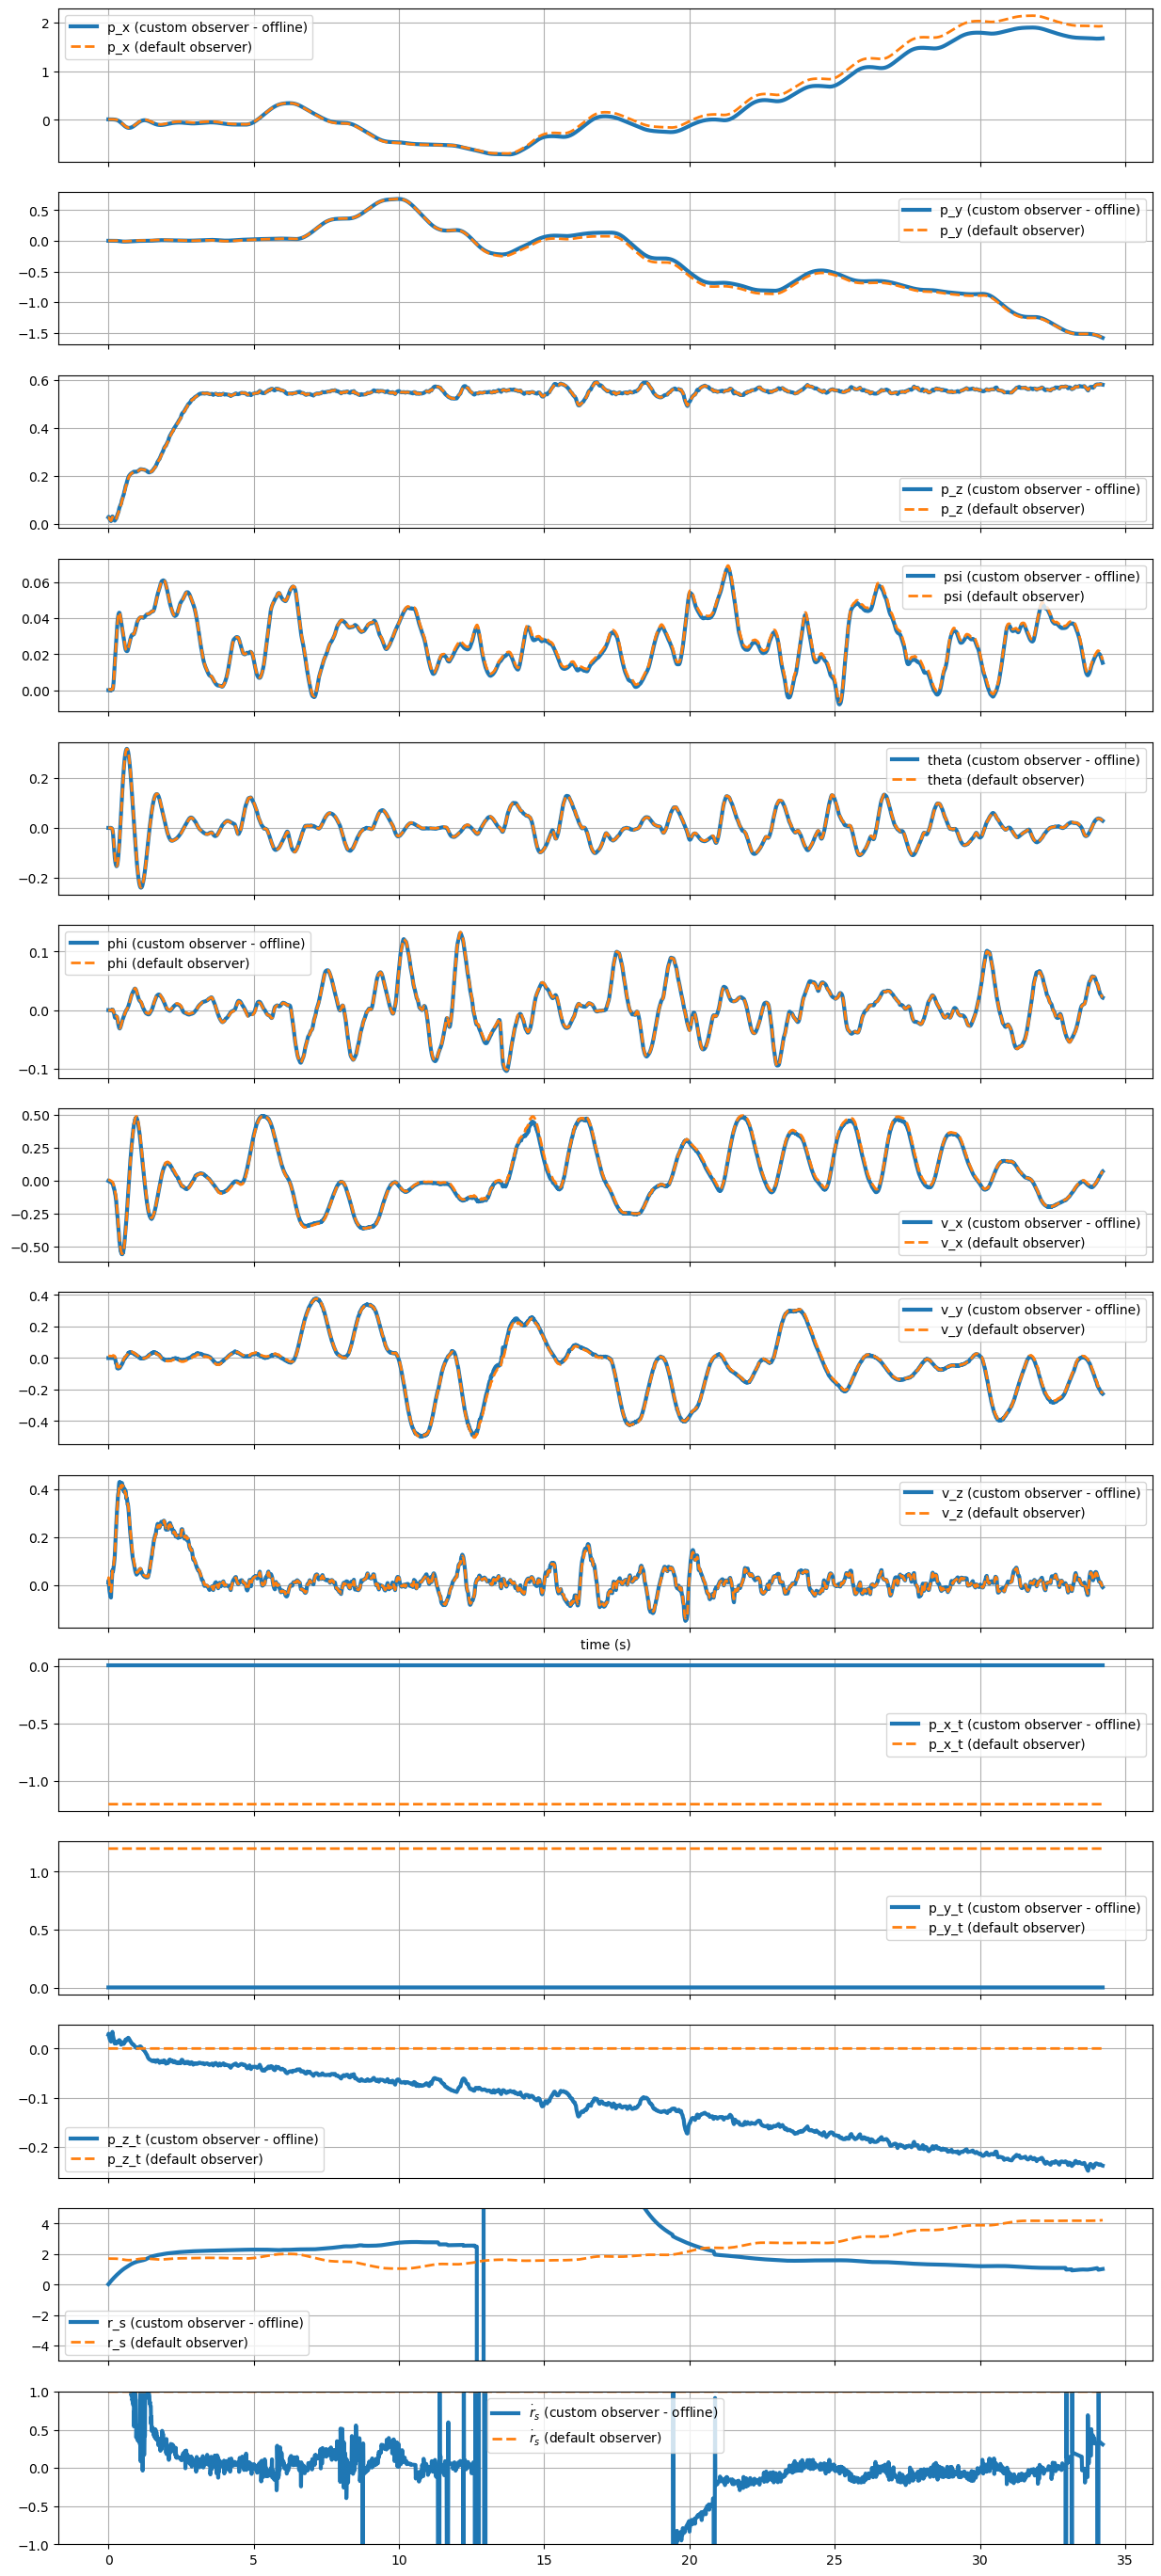

In [33]:
def comparison_plot(t, s_offline, s_default, name, ax, s_mocap=None):
    ax.plot(t, s_offline, label=f'{name} (custom observer - offline)', linewidth=3)
    ax.plot(t, s_default, '--', label=f'{name} (default observer)', linewidth=2)
    if s_mocap is not None:
        ax.plot(t, s_mocap, ':', label=f'{name} (mocap)', linewidth=4)
    ax.legend()
    ax.grid()

fig, (ax_p_x,
      ax_p_y,
      ax_p_z,
      ax_psi,
      ax_theta,
      ax_phi,
      ax_v_x,
      ax_v_y,
      ax_v_z,
      ax_p_x_t,
      ax_p_y_t,
      ax_p_z_t,
      ax_r_s,
      ax_r_s_dot) = plt.subplots(14, 1, figsize=(15, 35), sharex=True)
comparison_plot(t, p_x_offline, p_x_default, 'p_x', ax_p_x)
comparison_plot(t, p_y_offline, p_y_default, 'p_y', ax_p_y)
comparison_plot(t, p_z_offline, p_z_default, 'p_z', ax_p_z)
comparison_plot(t, psi_offline, psi_default, 'psi', ax_psi)
comparison_plot(t, theta_offline, theta_default, 'theta', ax_theta)
comparison_plot(t, phi_offline, phi_default, 'phi', ax_phi)
comparison_plot(t, v_x_offline, v_x_default, 'v_x', ax_v_x)
comparison_plot(t, v_y_offline, v_y_default, 'v_y', ax_v_y)
comparison_plot(t, v_z_offline, v_z_default, 'v_z', ax_v_z)
comparison_plot(t, p_x_t_w_offline, p_x_t_w * np.ones(len(t)), 'p_x_t', ax_p_x_t)
comparison_plot(t, p_y_t_w_offline, p_y_t_w * np.ones(len(t)), 'p_y_t', ax_p_y_t)
comparison_plot(t, p_z_t_w_offline, p_z_t_w * np.ones(len(t)), 'p_z_t', ax_p_z_t)
comparison_plot(t, r_s_offline, r_s_default, 'r_s', ax_r_s)
comparison_plot(t, r_s_dot_offline, np.ones(len(t)), r'$\dot{r}_s$', ax_r_s_dot)
ax_v_z.set_xlabel('time (s)')

ax_r_s.set_ylim([-5., 5.])
ax_r_s_dot.set_ylim([-1., 1.])

plt.show()

Plot error in each state estimate with respect to ground truth.

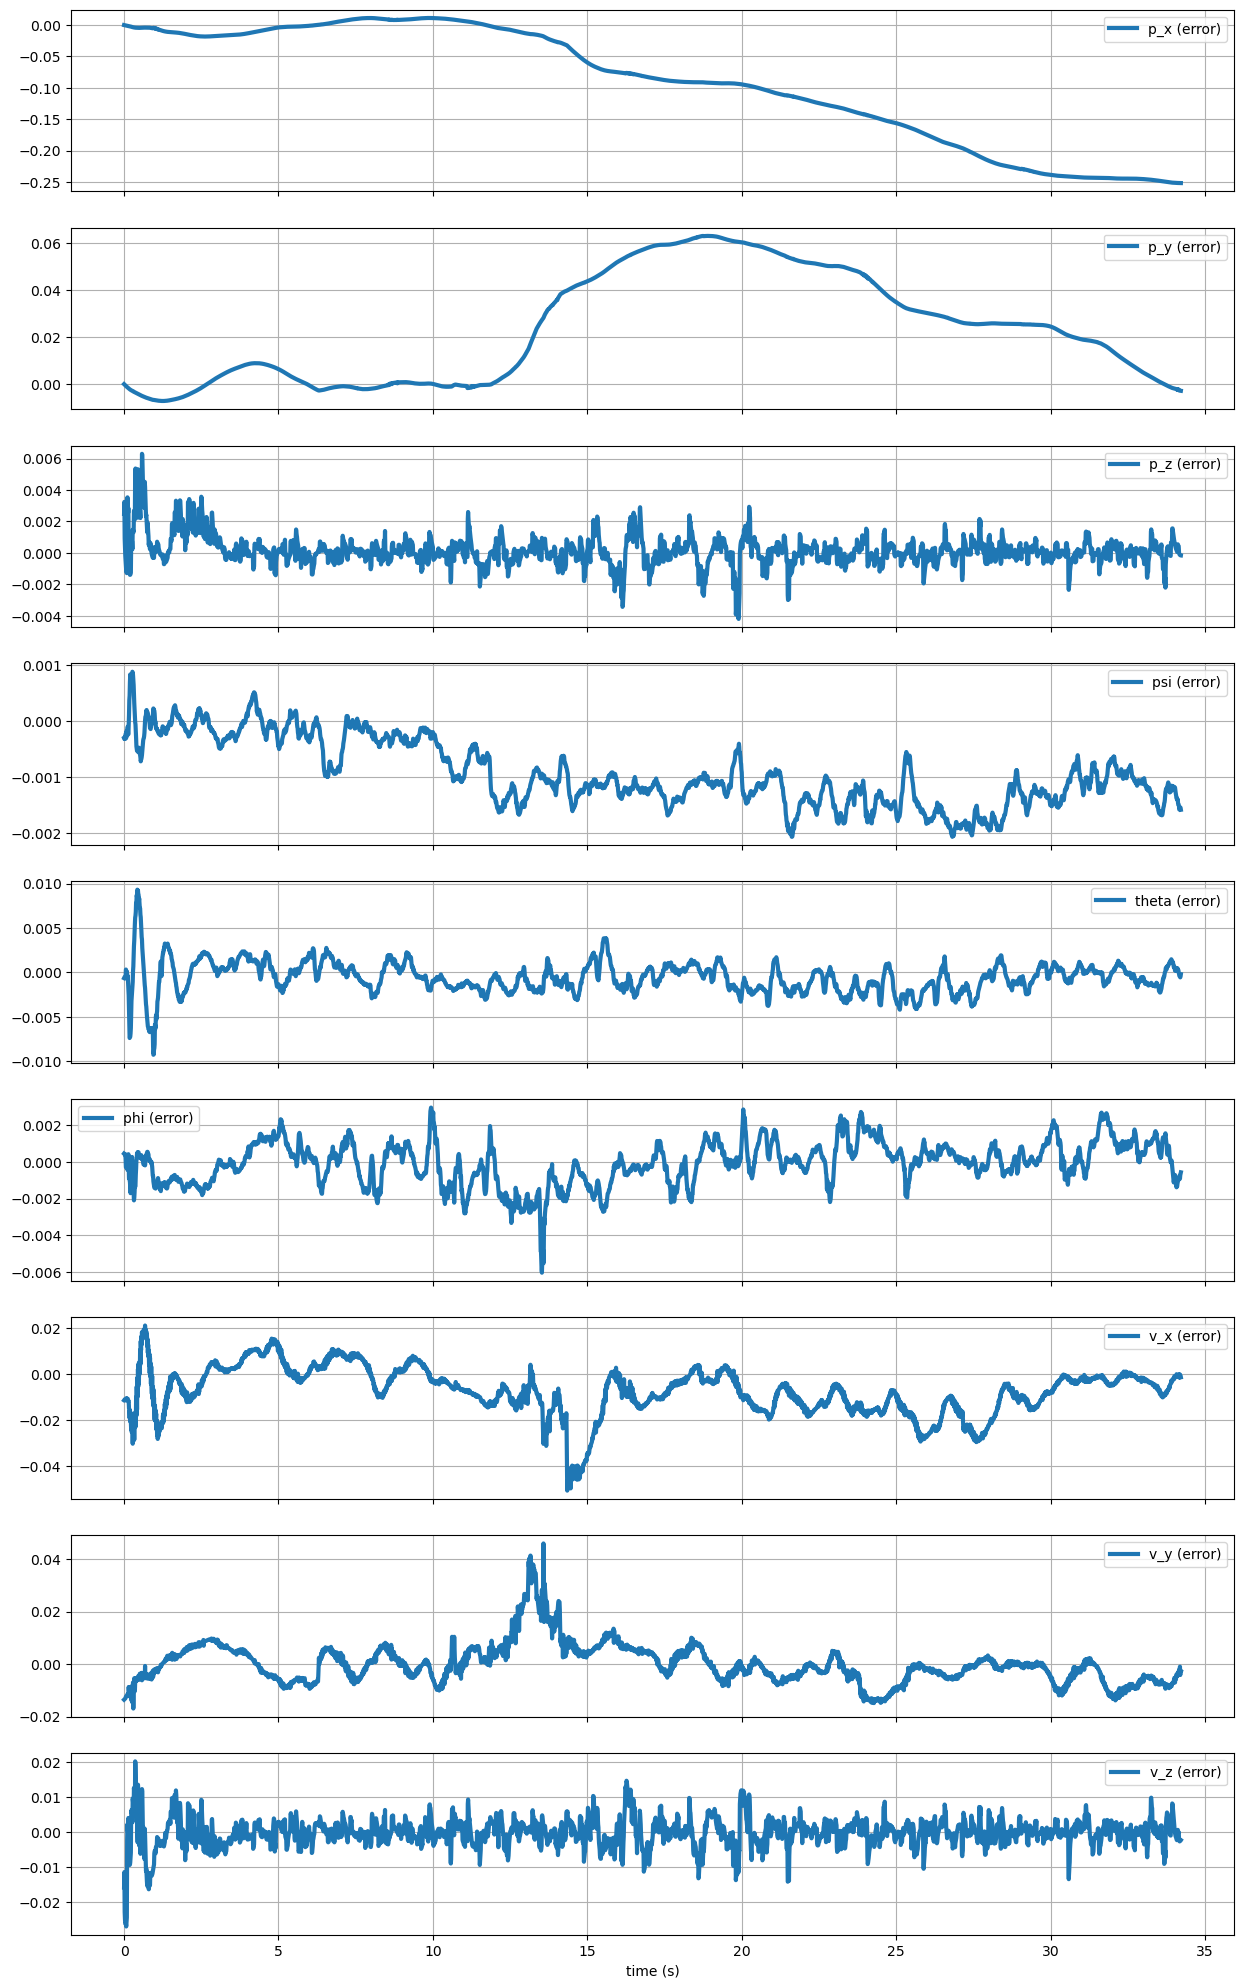

In [27]:
def error_plot(t, s_err, name, ax):
    ax.plot(t, s_err, label=f'{name} (error)', linewidth=3)
    ax.legend()
    ax.grid()

fig, (ax_p_x,
      ax_p_y,
      ax_p_z,
      ax_psi,
      ax_theta,
      ax_phi,
      ax_v_x,
      ax_v_y,
      ax_v_z) = plt.subplots(9, 1, figsize=(15, 25), sharex=True)
error_plot(t, p_x_err, 'p_x', ax_p_x)
error_plot(t, p_y_err, 'p_y', ax_p_y)
error_plot(t, p_z_err, 'p_z', ax_p_z)
error_plot(t, psi_err, 'psi', ax_psi)
error_plot(t, theta_err, 'theta', ax_theta)
error_plot(t, phi_err, 'phi', ax_phi)
error_plot(t, v_x_err, 'v_x', ax_v_x)
error_plot(t, v_y_err, 'v_y', ax_v_y)
error_plot(t, v_z_err, 'v_z', ax_v_z)
ax_v_z.set_xlabel('time (s)')
plt.show()

Plot histogram of errors in each state estimate.

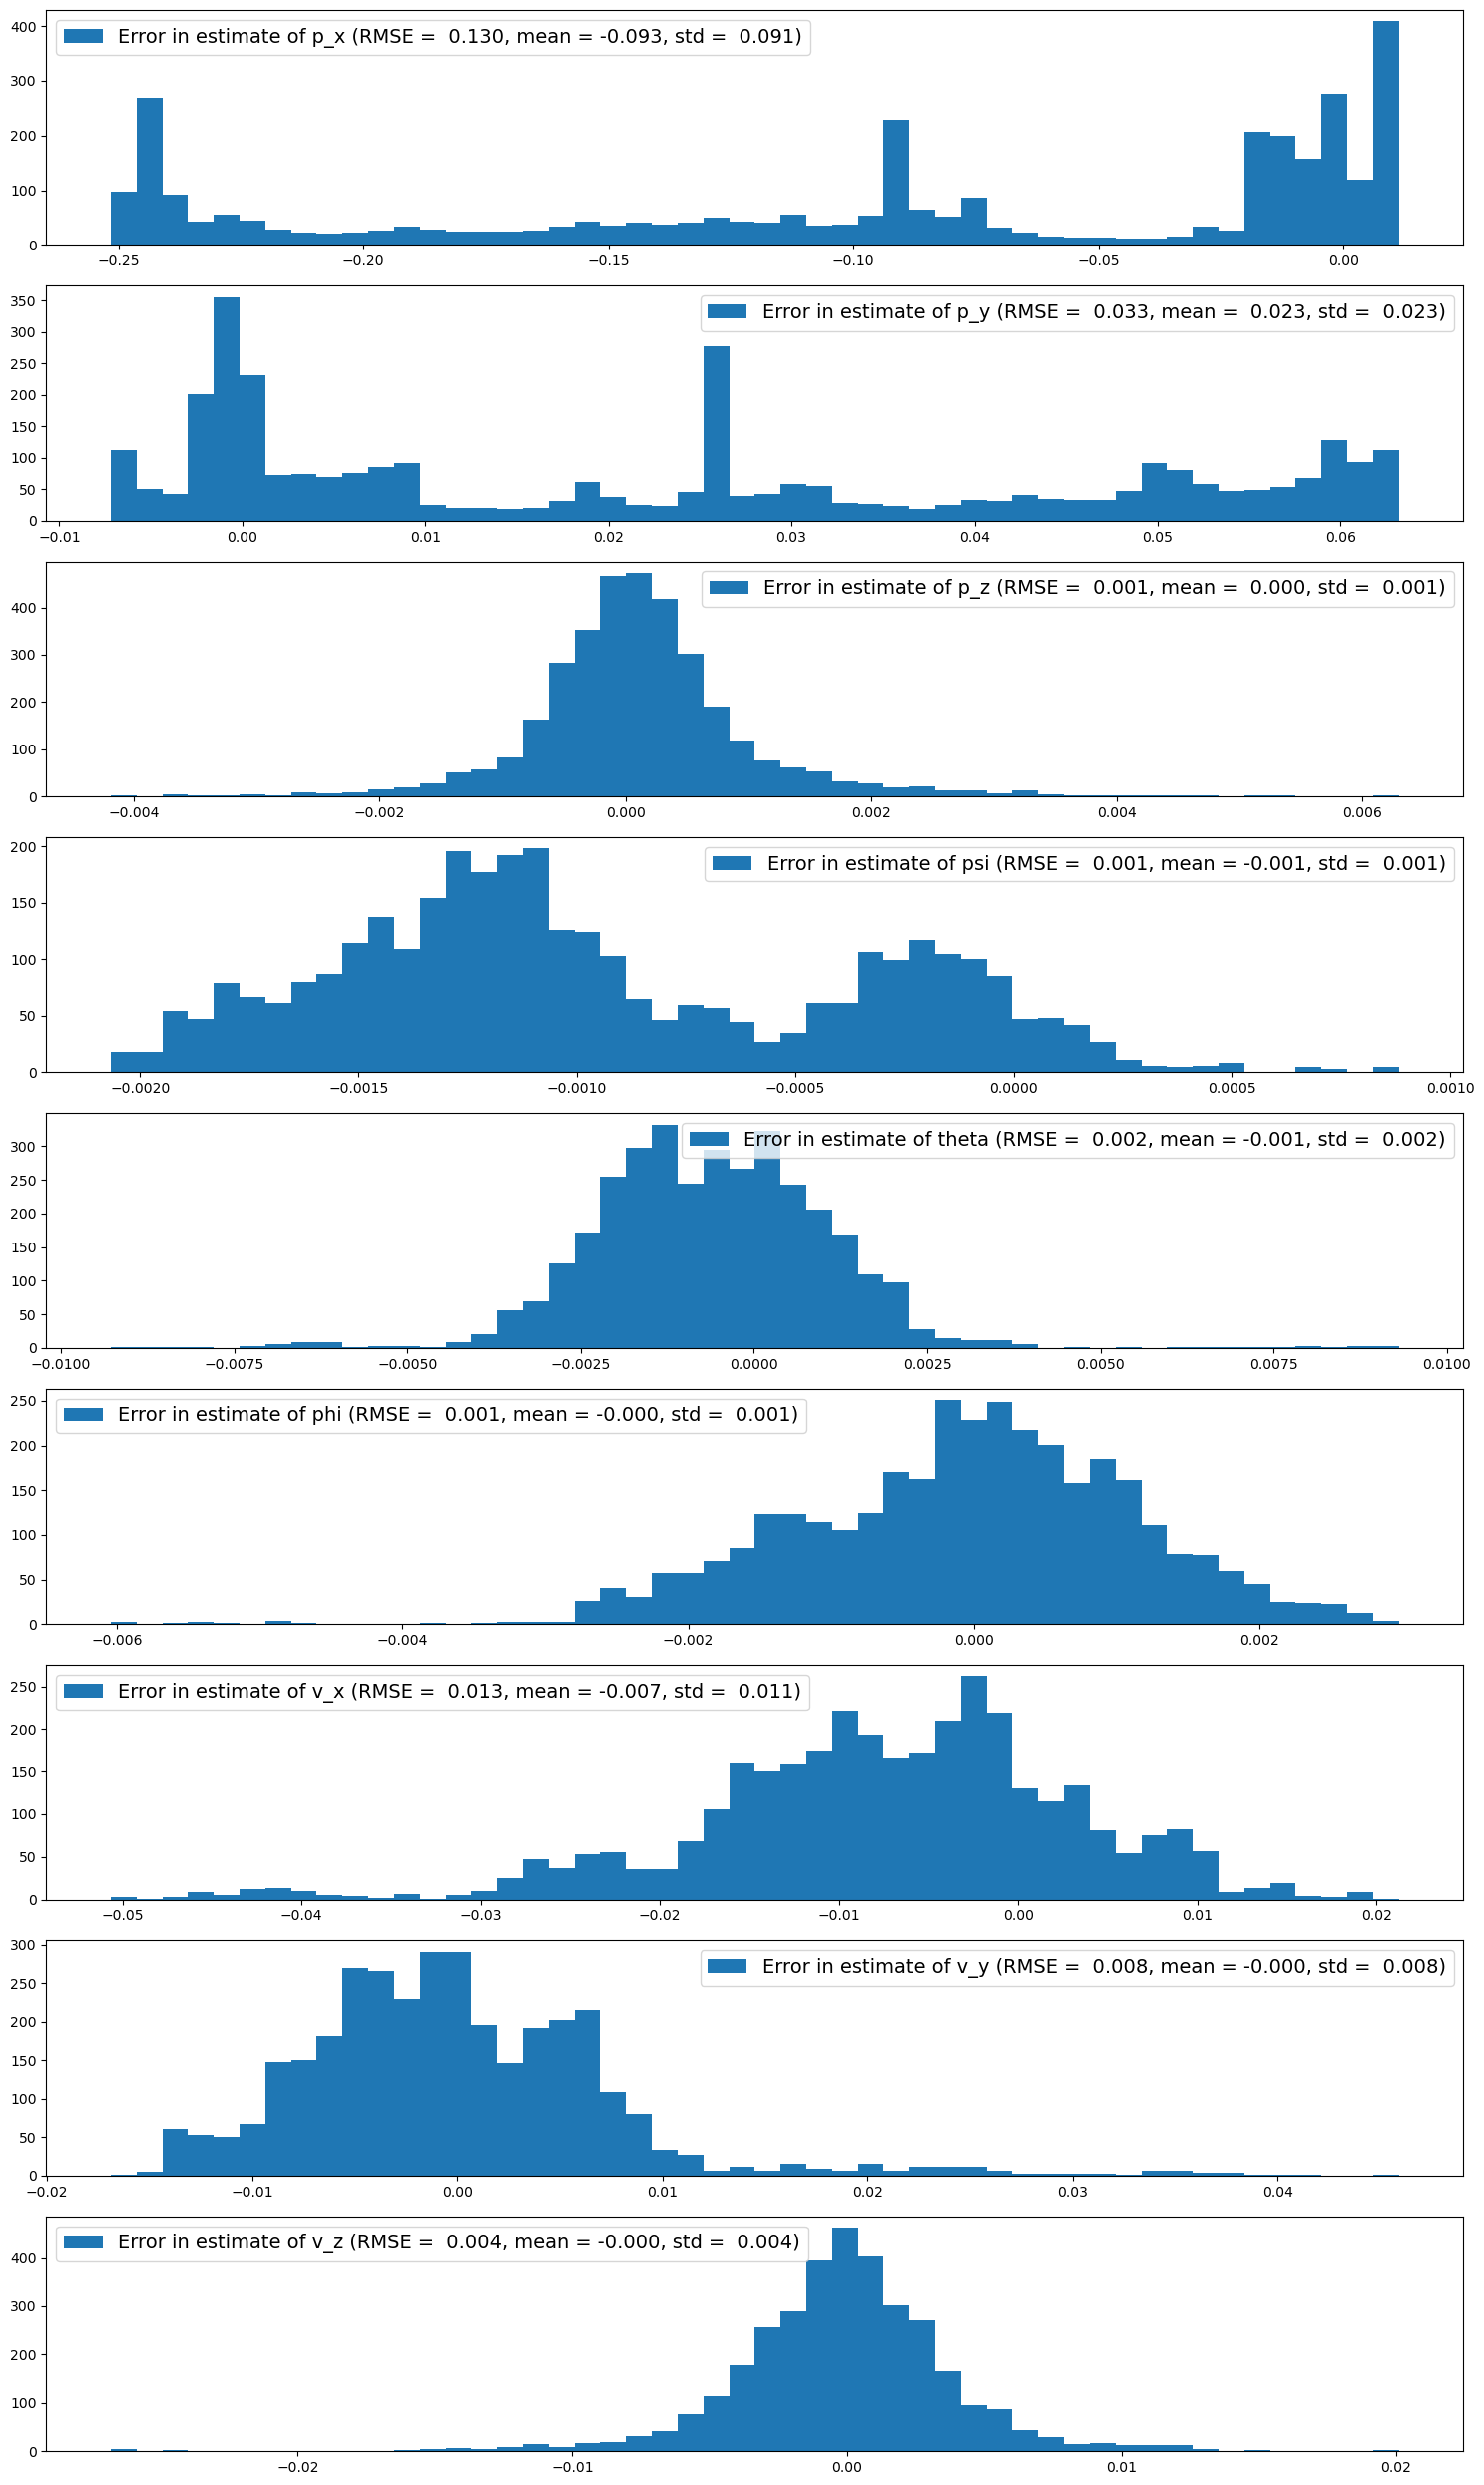

In [28]:
def histogram_plot(t, s_err, name, ax):
    label = f'Error in estimate of {name} ' + \
            f'(RMSE = {np.sqrt(np.mean(s_err**2)):6.3f}, ' + \
            f'mean = {np.mean(s_err):6.3f}, ' + \
            f'std = {np.std(s_err):6.3f})'
    ax.hist(s_err, 50, label=label)
    ax.legend(fontsize=14)

fig, (ax_p_x,
      ax_p_y,
      ax_p_z,
      ax_psi,
      ax_theta,
      ax_phi,
      ax_v_x,
      ax_v_y,
      ax_v_z) = plt.subplots(9, 1, figsize=(15, 25))
histogram_plot(t, p_x_err, 'p_x', ax_p_x)
histogram_plot(t, p_y_err, 'p_y', ax_p_y)
histogram_plot(t, p_z_err, 'p_z', ax_p_z)
histogram_plot(t, psi_err, 'psi', ax_psi)
histogram_plot(t, theta_err, 'theta', ax_theta)
histogram_plot(t, phi_err, 'phi', ax_phi)
histogram_plot(t, v_x_err, 'v_x', ax_v_x)
histogram_plot(t, v_y_err, 'v_y', ax_v_y)
histogram_plot(t, v_z_err, 'v_z', ax_v_z)
fig.tight_layout()
plt.show()

## 3.3 Apply observer for gain matrix chosen by weights from model error variance

**FIXME.** Copy all cells from Section 3.2 here. Then, modify your observer implementation to use weights $Q$ and $R$ chosen by looking at model error variance.

## 3.4 Summary and discussion

The following table reports the RMSE in each state estimate:

|  | $p_x$ | $p_y$ | $p_z$ | $\psi$ | $\theta$ | $\phi$ | $v_x$ | $v_y$ | $v_z$ |
| --: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: |
| RMSE with equal weights | 0.001 | 0.002 | 0.003 | 0.004 | 0.005 | 0.006 | 0.007 | 0.008 | 0.009 |
| RMSE with weights from error model variance | 0.001 | 0.002 | 0.003 | 0.004 | 0.005 | 0.006 | 0.007 | 0.008 | 0.009 |

**Modify the text in this cell** to answer the following questions:

* Which observer performs better, the one derived from equal weights or the one derived from weights based on error model variance? Why? (Make reference to your table of results when answering this question.)
* Is there a difference in what happens to the error in your estimate of (1) observable states and (2) non-observable states over time? Why? (Make reference to your plots when answering this question.)
* We have defined "error" as the difference between the state estimates from your custom observer (implemented offline) and the state estimates from the default observer. Are the state estimates from the default observer really correct? To what extent are any of these estimates the same as what you get from the motion capture system? (Think about the difference between observable and non-observable states when answering this question.)